In [6]:
import numpy as np
import pip
import torch
from torch import nn
import argparse
from torch.autograd import Variable
import io
from scipy import linalg

In [7]:
def load_pretrained_embeddings(path):
    """
    Reload pretrained embeddings from a text file.
    """
    word2id = {}
    vectors = []
    id2word={}
    emb_path =path
    _emb_dim_file = 300
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        for i, line in enumerate(f):
            if i == 0:
                split = line.split()
               
            else:
                word, vect = line.rstrip().split(' ', 1)
                
                word = word.lower()
                vect = np.fromstring(vect, sep=' ')
                if np.linalg.norm(vect) == 0:  # avoid to have null embeddings
                    vect[0] = 0.01
               
                word2id[word] = len(word2id)
                id2word[len(word2id)]=word
                vectors.append(vect[None])
            if len(word2id) >= 200000:
                break

    
    print("Loaded %i pre-trained word embeddings." % len(vectors))


    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.concatenate(vectors, 0)
    embeddings = torch.from_numpy(embeddings).float()
    embeddings = embeddings
    
    return embeddings,word2id,id2word


In [8]:
def get_dis_xy(bs, src_emb,tgt_emb):
        """
        Get discriminator input batch / output target.
        """
        # select random word IDs
        #bs = self.params.batch_size
        mf = 75000
        #assert mf <= min(len(self.src_dico), len(self.tgt_dico))
        src_ids = torch.LongTensor(bs).random_(mf)
        tgt_ids = torch.LongTensor(bs).random_(mf)
        
        src_ids = src_ids.cuda()
        tgt_ids = tgt_ids.cuda()

        # get word embeddings
        src_emb = src_emb(Variable(src_ids))
        tgt_emb = tgt_emb(Variable(tgt_ids))
        src_emb = mapping(Variable(src_emb.data))
        tgt_emb = Variable(tgt_emb.data)

        # input / target
        x = torch.cat([src_emb, tgt_emb], 0)
        y = torch.FloatTensor(2 * bs).zero_()
        y[:bs] = 1 - 0.2
        y[bs:] = 0.2
        y = Variable(y.cuda())

        return x, y

In [9]:
src_embedding,src_word2id,src_id2word=load_pretrained_embeddings("data/wiki.en.vec")
tgt_embedding,tgt_word2id,tgt_id2word=load_pretrained_embeddings("data/wiki.es.vec")

Loaded 200000 pre-trained word embeddings.
Loaded 200000 pre-trained word embeddings.


In [10]:
src_embeddings = nn.Embedding(200000, 300, sparse=True)
src_embeddings.weight.data.copy_(src_embedding)

tgt_embeddings = nn.Embedding(200000, 300, sparse=True)
tgt_embeddings.weight.data.copy_(tgt_embedding)

src_embeddings.cuda()
tgt_embeddings.cuda()

Embedding(200000, 300, sparse=True)

In [11]:

def get_batch2(X,batch_size):
 
#     N = X.size()[0]
    N=200000
    batch_indices = torch.LongTensor( np.random.randint(0,N,size=batch_size) )

    batch_xs = X(Variable(batch_indices).cuda())

    return batch_xs.cuda()

In [12]:
class Discriminator(nn.Module):

    def __init__(self, dis_hid_dim,dis_dropout,dis_input_dropout):
        super(Discriminator, self).__init__()

        self.emb_dim = 300
        self.dis_layers = 2
        self.dis_hid_dim = dis_hid_dim
        self.dis_dropout = dis_dropout
        self.dis_input_dropout = dis_input_dropout

        layers = [nn.Dropout(self.dis_input_dropout)]
        for i in range(self.dis_layers + 1):
            input_dim = self.emb_dim if i == 0 else self.dis_hid_dim
            output_dim = 1 if i == self.dis_layers else self.dis_hid_dim
            layers.append(nn.Linear(input_dim, output_dim))
            if i < self.dis_layers:
                layers.append(nn.LeakyReLU(0.2))
                layers.append(nn.Dropout(self.dis_dropout))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        assert x.dim() == 2 and x.size(1) == self.emb_dim
        return self.layers(x).view(-1)

In [13]:

def Orthogonal(mapping,beta):
    W=mapping.weight.data
    mapping.weight.data.copy_((1 + beta) * W - beta * W.mm(W.transpose(0, 1).mm(W)))
    return mapping


In [14]:
#set up linear mapping,
mapping = nn.Linear(300, 300, bias=False)
mapping.weight.data.copy_(torch.eye(300))
modelDisc= Discriminator(2048,0,0.1)
mapping.cuda()
modelDisc.cuda()

Discriminator(
  (layers): Sequential(
    (0): Dropout(p=0.1)
    (1): Linear(in_features=300, out_features=2048, bias=True)
    (2): LeakyReLU(0.2)
    (3): Dropout(p=0)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): LeakyReLU(0.2)
    (6): Dropout(p=0)
    (7): Linear(in_features=2048, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [15]:
def get_csls(src_emb, tgt_emb, knn=10):
 
    bs = 1024
    all_distances = []
#     emb = tgt_emb.transpose(0, 1).contiguous()
    emb=tgt_emb.transpose(0,1)
    for i in range(0, src_emb.shape[0], bs):
        distances = src_emb[i:i + bs].mm(emb)
        best_distances, _ = distances.topk(knn, dim=1, largest=True, sorted=True)
        all_distances.append(best_distances.mean(1).cpu())
    all_distances = torch.cat(all_distances)
    return all_distances.numpy()

def get_neighbour(emb1,emb2):
    bs = 128

    all_scores = []
    all_targets = []

    # number of source words to consider
    n_src = emb1.size(0)
    n_src =30000
    knn = 10

        # average distances to k nearest neighbors
    average_dist1 = torch.from_numpy(get_csls(emb1, emb2, knn))
    average_dist2 = torch.from_numpy(get_csls(emb2, emb1, knn))
    average_dist1 = average_dist1.type_as(emb1)
    average_dist2 = average_dist2.type_as(emb2)

    # for every source word
    for i in range(0, n_src, bs):

        # compute target words scores
        scores = emb2.mm(emb1[i:min(n_src, i + bs)].transpose(0, 1)).transpose(0, 1)
        scores.mul_(2)
        scores.sub_(average_dist1[i:min(n_src, i + bs)][:, None] + average_dist2[None, :])
        best_scores, best_targets = scores.topk(2, dim=1, largest=True, sorted=True)

        # update scores / potential targets
        all_scores.append(best_scores.cpu())
        all_targets.append(best_targets.cpu())

    all_scores = torch.cat(all_scores, 0)
    all_targets = torch.cat(all_targets, 0)

    all_pairs = torch.cat([torch.arange(0, all_targets.size(0)).long().unsqueeze(1),all_targets[:, 0].unsqueeze(1)], 1)
    assert all_scores.size() == all_pairs.size() == (n_src, 2)

    # sort pairs by score confidence
    diff = all_scores[:, 0] - all_scores[:, 1]
    reordered = diff.sort(0, descending=True)[1]
    all_scores = all_scores[reordered]
    all_pairs = all_pairs[reordered]
    
    
    selected = all_pairs.max(1)[0] <= 30000
    mask = selected.unsqueeze(1).expand_as(all_scores).clone()
    all_scores = all_scores.masked_select(mask).view(-1, 2)
    all_pairs = all_pairs.masked_select(mask).view(-1, 2)
    return all_pairs


In [16]:

def create_dictionary(src_embedding,tgt_embedding):
    src2tgt = get_neighbour(src_embedding,tgt_embedding)
    tgt2src = get_neighbour(tgt_embedding,src_embedding)
    
    tgt2src = torch.cat([tgt2src[:, 1:], tgt2src[:, :1]], 1)
    
    s2t_candidates = set([(a, b) for a, b in src2tgt])
    t2s_candidates = set([(a, b) for a, b in tgt2src])
#     print(s2t_candidates)
    final_pairs = s2t_candidates & t2s_candidates
    if len(final_pairs) == 0:
        print("warning")
        return None
    dictionary = torch.LongTensor(list([[a, b] for (a, b) in final_pairs]))

    print('New train dictionary of %i pairs.' % dictionary.size(0))
    return dictionary.cuda()
    
        
# def build_dictionary(src_emb, tgt_emb, _params, s2t_candidates, t2s_candidates):
    

In [17]:
def evaluation_metric(src_embs, tgt_embs):
     
        indices= torch.LongTensor(np.arange(200000))
        batch_xs = src_embs(Variable(indices).cuda())
        src_emb = mapping(batch_xs.cuda())
        src_emb=torch.FloatTensor(src_emb.cpu().data.numpy()).cuda()
        tgt_emb = tgt_embs(Variable(indices).cuda())
        tgt_emb=torch.FloatTensor(tgt_emb.cpu().data.numpy()).cuda()
        src_emb = src_emb / src_emb.norm(2, 1, keepdim=True).expand_as(src_emb)
        tgt_emb = tgt_emb / tgt_emb.norm(2, 1, keepdim=True).expand_as(tgt_emb)
        print(type(src_emb))

        #s2t_candidates = get_candidates(src_emb, tgt_emb, _params)
        #t2s_candidates = get_candidates(tgt_emb, src_emb, _params)
        
        dictionary = create_dictionary(src_emb, tgt_emb)
        dictionary_max_size = 10000
        if dictionary is None:
            mean_cosine=0
        else:
            mean_cosine = (src_emb[dictionary[:dictionary_max_size, 0]] * tgt_emb[dictionary[:dictionary_max_size, 1]]).sum(1).mean()
        print("Mean cosine", mean_cosine)
        return mean_cosine
            

In [18]:
linoptimizer = torch.optim.SGD(mapping.parameters(), lr=0.1)
discoptimizer= torch.optim.SGD(modelDisc.parameters(), lr=0.1)

loss_fn=torch.nn.BCELoss()

def get_xy():
#get minibatch of spanish words
    spanish_batch=get_batch2(tgt_embeddings,batch_size)
    #getminibatch of english words
    english_batch=get_batch2(src_embeddings,batch_size)

    #generate fake spanish embeddings
    s_fake= mapping(english_batch)

    #stack real and fake
    x = torch.cat([s_fake, spanish_batch], 0)
    #         print(x.shape)
    y = torch.FloatTensor(2 * batch_size).zero_()
    
    y[batch_size:] = 0.2
    y[:batch_size]=1-0.2
    y=Variable(y).cuda()
    return x,y

In [19]:
iterations_per_epoch=1000000
batch_size=32
epoch=2
val_score=-1

for _ in range(epoch):
      
    for _n in range(0,iterations_per_epoch,batch_size):
        modelDisc.train()
        mapping.eval()
        for __ in range(5):

            x,y=get_xy()
            #x,y=get_dis_xy(32,src_embeddings,tgt_embeddings)
            y_pred = modelDisc(Variable(x.data))
       


            loss= loss_fn(y_pred, y)

            discoptimizer.zero_grad()


       
            loss.backward()
    #         print(loss.data)

           
            discoptimizer.step()
          
        modelDisc.eval()
        mapping.train()
        for __ in range(1):
            
            x,y=get_xy()
            #x,y=get_dis_xy(32,src_embeddings,tgt_embeddings)
            y=1-y
            y_pred = modelDisc(x)
            loss2= loss_fn(y_pred, y)
            linoptimizer.zero_grad()
            loss2.backward()
            linoptimizer.step()

            mapping=Orthogonal(mapping,0.001)
        if _n%500==0:
            print(torch.norm(mapping.weight.data,2))
            print(_n," Discriminator Loss :  ",loss.data)
            print("Generator Loss : ", loss2.data)
        
    val=evaluation_metric(src_embeddings,tgt_embeddings)
    if val_score<val:
        torch.save(mapping.state_dict(), './mapping.pth')
        val_score=val
    

    
    

17.3204269409
(0, ' Discriminator Loss :  ', 
 0.6736
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.7218
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
17.2290706635
(4000, ' Discriminator Loss :  ', 
 0.6125
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.8372
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
17.0373191833
(8000, ' Discriminator Loss :  ', 
 0.5586
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.1799
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.8897361755
(12000, ' Discriminator Loss :  ', 
 0.5679
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.0062
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.759645462
(16000, ' Discriminator Loss :  ', 
 0.6361
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.0220
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.6194076538
(20000, ' Discriminator Loss :  ', 
 0.5901
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generat

KeyboardInterrupt: 

In [20]:
def build_dictionary(src_emb,tgt_emb):
    src_emb = mapping(Variable(src_emb, requires_grad=False).cuda())
    src_emb=torch.FloatTensor(src_emb.cpu().data.numpy()).cuda()
    tgt_emb = tgt_emb.cuda()
    src_emb = src_emb / src_emb.norm(2, 1, keepdim=True).expand_as(src_emb)
    tgt_emb = tgt_emb / tgt_emb.norm(2, 1, keepdim=True).expand_as(tgt_emb)


#         s2t_candidates = get_candidates(src_emb, tgt_emb, _params)
#         t2s_candidates = get_candidates(tgt_emb, src_emb, _params)
    dictionary= create_dictionary(src_emb, tgt_emb)
    return dictionary

dictionary=build_dictionary(src_embedding,tgt_embedding)

    

New train dictionary of 1737 pairs.


In [83]:
def procrustes(src_emb,tgt_emb):
    A = src_emb.weight.data[list(dictionary[:, 0])]
    B = tgt_emb.weight.data[list(dictionary[:, 1])]
    M = B.transpose(0, 1).mm(A).cpu().numpy()
    U, S, V_t = linalg.svd(M, full_matrices=True)
    mapping.weight.data.copy_(torch.from_numpy(U.dot(V_t)).type_as(mapping.weight.data))


In [85]:
for i in range(5):
    procrustes(src_embeddings,tgt_embeddings)
    evaluation_metric(src_embeddings.cuda(),tgt_embeddings.cuda())
    val=evaluation_metric(src_embeddings,tgt_embeddings)
    if val_score<val:
        torch.save(mapping.state_dict(), './mapping.pth')
    

<class 'torch.cuda.FloatTensor'>
New train dictionary of 14371 pairs.
('Mean cosine', 0.7212909460067749)
<class 'torch.cuda.FloatTensor'>
New train dictionary of 14371 pairs.
('Mean cosine', 0.7212909460067749)
<class 'torch.cuda.FloatTensor'>
New train dictionary of 14371 pairs.
('Mean cosine', 0.7212909460067749)
<class 'torch.cuda.FloatTensor'>
New train dictionary of 14371 pairs.
('Mean cosine', 0.7212909460067749)
<class 'torch.cuda.FloatTensor'>


KeyboardInterrupt: 

In [58]:
# # spanish_embeddings
# tgt_emb2=tgt_embeddings.cpu().numpy()
# # print(tgt_emd.shape)


# def get_nn(word_emb, tgt_emb, tgt_id2word, K=5):
  
#     scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
#     k_best = scores.argsort()[-K:][::-1]
#     for i, idx in enumerate(k_best):
#         print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [59]:
# def create_map(words,language):
#     id2word={}
#     for word in words:
#         id=language.get_word_id(word)
#         id2word[id]=word
#     return id2word
# spanish_map=create_map(Swords,spanish)
        

In [60]:
# cat_embedding=mapping(Variable(src_embeddings[src_word2id['same']],requires_grad=False).cuda()).cpu().data
# word_emd=cat_embedding.numpy()
# get_nn(word_emd,tgt_emb,tgt_id2word)


In [61]:
# cat_embedding=tgt_embeddings[tgt_word2id['misma']]
# word_emd=cat_embedding.numpy()
# get_nn(word_emd,fake_src_embeddings.cpu().numpy(),src_id2word)


In [87]:
fake_src_embeddings=(mapping(Variable(src_embedding, requires_grad=False).cuda())).cuda()
# tgt_embeddings=(tgt_embeddings).cuda()

In [88]:
fake_src_embeddings=torch.FloatTensor(fake_src_embeddings.cpu().data.numpy())
# # type(fake_src_embeddings)
# # src_embedding=src_embeddings.cpu().detach().numpy()
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([fake_src_embeddings, tgt_embedding]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())
# src_emb=fake_src_embeddings/fake_src_embeddings.norm(2, 1, keepdim=True).expand_as(fake_src_embeddings)
# tgt_emb = tgt_embeddings / tgt_embeddings.norm(2, 1, keepdim=True).expand_as(tgt_embeddings)

Variance explained: 0.07


In [64]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()
    

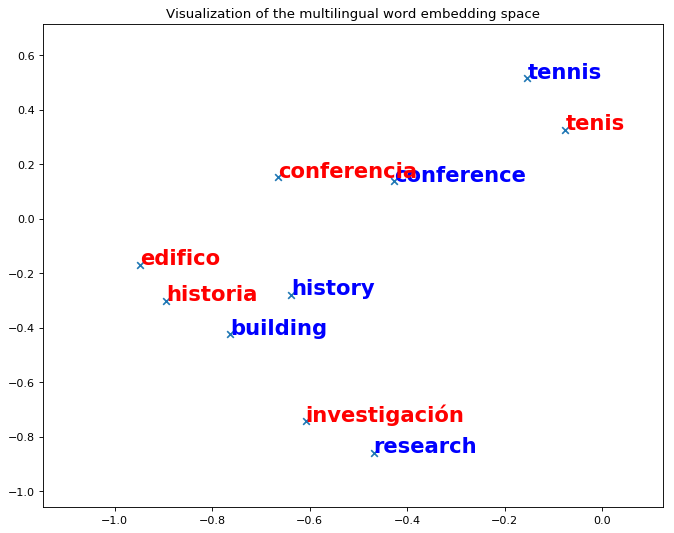

In [90]:
# src_words = ['dog', 'the', 'me', 'tennis', 'cat', 'conference']
# tgt_words = ['perro', 'el', 'yo', u'tenis',  'gato', 'conferencia']
src_words = ['building',  'history', 'tennis', 'research', 'conference']
tgt_words = ['edifico', 'historia', u'tenis',  u'investigación', 'conferencia']
plot_similar_word(src_words,src_word2id,fake_src_embeddings.cpu().numpy(),tgt_words,tgt_word2id,tgt_embedding.cpu().numpy(),pca)
# # english.get_word_id

In [28]:
# dico=create_dictionary(src_emb,tgt_emb)
# print(type(src_embedding))

In [29]:
# fake_src_embeddings2=(mapping(Variable(src_embeddings, requires_grad=False).cuda())).cuda()

In [30]:
# cat_embedding=mapping(Variable(src_embeddings[src_word2id['the']],requires_grad=False).cuda()).cpu().data
# word_emd=cat_embedding.numpy()
# get_nn(word_emd,tgt_embeddings.cpu().numpy(),tgt_id2word)

In [69]:
evaluation_metric(src_embeddings,tgt_embeddings)

<class 'torch.cuda.FloatTensor'>
New train dictionary of 11977 pairs.
('Mean cosine', 0.6451402902603149)


0.6451402902603149